# Driver

In [59]:
%load_ext IPython.extensions.autoreload
%autoreload 2

The IPython.extensions.autoreload extension is already loaded. To reload it, use:
  %reload_ext IPython.extensions.autoreload


In [60]:
import sys,os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [61]:
import numpy as np
from src.data_reader import DataSource, read_vertices_VTK, num_vertices_VTK
from src.descriptors.dscs_driver import compute_descriptors

from src.utils import get_free_id, write_jsonl, clear_jsonl

!pip install numpy==1.23.0

In [62]:
from ripser import ripser
from persim import plot_diagrams

In [63]:
from gudhi import RipsComplex, AlphaComplex, plot_persistence_diagram
from gudhi.representations import ProminentPoints
from gudhi.representations import PersistenceImage

In [75]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import AdaBoostClassifier

import joblib

In [65]:
import csv

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary as torch_summary

from IPython.display import display, clear_output

from src.learning.nn import SimpleNN, train, predict

In [29]:
# number of prominent points to keep for each dimension for each PD
Num_Prominent = 150
# resolution of each axis for the persistent images
PersImPoints = 5

# Topological Descriptors

In [30]:
# log file for run
run_log = './runs/descriptors/runs.jsonl'
# get a new run id
run_id = get_free_id(run_log)

# data base path
data_base = './data/data/'
# data source
data_source = os.path.join(data_base, 'train_set/')

# set params for the run
#Model = 'AlphaProminent'
#Model = 'quantiles'

Model = 'Combined'

params = { 'data':data_base}
params.update(  { 'Num_Prominent' : Num_Prominent , 'PersImPoints' : PersImPoints } )
params.update( { 'which_quantiles':[0.16666667, 0.33333333, 0.5       , 0.66666667, 0.83333333] } )

data, labels = compute_descriptors(data_source, model=Model, **params)


# save descriptors
save_descs_path = os.path.join(data_base,'saved_descriptors/')

# save
np.save(os.path.join(save_descs_path, Model+'Data.npy'), data)
np.save(os.path.join(save_descs_path, Model+'Labels.npy'), np.array(labels) )

# Logging
log_params = {'id':run_id, 'Model':Model}
log_params.update(params)
write_jsonl(run_log, log_params)

1 out of 9244
/home/marco/CodeImati/SHREC25/data/data/train_set/105m_1:A:A_model1.vtk
2 out of 9244
/home/marco/CodeImati/SHREC25/data/data/train_set/107m_1:A:A_model1.vtk
3 out of 9244
/home/marco/CodeImati/SHREC25/data/data/train_set/110m_1:A:A_model1.vtk
4 out of 9244
/home/marco/CodeImati/SHREC25/data/data/train_set/112m_1:A:A_model1.vtk
5 out of 9244
/home/marco/CodeImati/SHREC25/data/data/train_set/1a6g_1:A:A_model1.vtk
6 out of 9244
/home/marco/CodeImati/SHREC25/data/data/train_set/1a6m_1:A:A_model1.vtk
7 out of 9244
/home/marco/CodeImati/SHREC25/data/data/train_set/1a6n_1:A:A_model1.vtk
8 out of 9244
/home/marco/CodeImati/SHREC25/data/data/train_set/1abs_1:A:A_model1.vtk
9 out of 9244
/home/marco/CodeImati/SHREC25/data/data/train_set/1agr_1:A:A_model1.vtk
10 out of 9244
/home/marco/CodeImati/SHREC25/data/data/train_set/1agr_1:B:D_model1.vtk
11 out of 9244
/home/marco/CodeImati/SHREC25/data/data/train_set/1as0_1:A:A_model1.vtk
12 out of 9244
/home/marco/CodeImati/SHREC25/data/da

In [12]:
np.save(os.path.join(save_descs_path, Model+'Data.npy'), data)
np.save(os.path.join(save_descs_path, Model+'Labels.npy'), np.array(labels) )

In [10]:
res = np.load('/home/marco/CodeImati/SHREC25/data/data/sublevelset_filtrations/train_set/105m_1:A:A_model1.vtk.npz', allow_pickle=True)

In [17]:
res.files

['dgm0', 'dgm1', 'dgm2', 'gens', 'allow_pickle']

### Reload descriptors

In [143]:
# load descriptors

#Model='quantiles'

# data base path
data_base = './data/data/'

save_descs_path = os.path.join(data_base,'saved_descriptors/')

data = np.load(os.path.join(save_descs_path,Model+'Data.npy'))
labels = np.load(os.path.join(save_descs_path,Model+'Labels.npy'))

print(data.shape, labels.shape)

(9244, 17) (9244,)


Out of curiosity, combine the two

In [10]:
save_descs_path = os.path.join(data_base,'saved_descriptors/')

dataOld = np.load(os.path.join(save_descs_path,'PersImages.npy'))
#labels = np.load(os.path.join(save_descs_path,'quantilesLabels.npy'))

print(dataOld.shape)

(9244, 75)


In [11]:
data = np.concatenate( (data, dataOld), axis = 1)

# Dimensionality Reduction

In [531]:
# amount of variance to reach to choose how many components to keep for kernel PCA
TotVar = 0.99

# Which fraction of N_Files is the maximum number of dimensions acceptable
FractionOfN_Files = 10

#### PCA

In [231]:
Pca = PCA()
PcaData = Pca.fit_transform(data)

print(PcaData.shape)

# Cumulative sum of variance explained by each component
VarBreakdown = np.cumsum(Pca.explained_variance_) / np.sum(Pca.explained_variance_)

# Keep only as many as neeeded to explain TotVar of variance
Dims_to_keep = np.argwhere(VarBreakdown < TotVar).shape[0] + 1 # +1 to get above TotVar

print(Dims_to_keep, 'features explain more than',TotVar*100, '% of variance')

# BUT make sure it's not more than a fraction of N_Files
Dims_to_keep = min( Dims_to_keep , int(N_Files/FractionOfN_Files) )

print('Keeping', Dims_to_keep, 'features')

kPcaData = kPcaData[ : , 0:Dims_to_keep ]

data = kPcaData


(300, 27)
5 features explain more than 99.0 % of variance
Keeping 5 features


#### Kernel PCA

In [532]:
# setup radial basis function kernel PCA
kPca = KernelPCA(kernel='rbf')
kPcaData = kPca.fit_transform(data)

print(kPcaData.shape)

# Cumulative sum of variance explained by each component
VarBreakdown = np.cumsum(kPca.eigenvalues_) / np.sum(kPca.eigenvalues_)
# Keep only as many as neeeded to explain TotVar of variance
Dims_to_keep = np.argwhere(VarBreakdown < TotVar).shape[0] + 1 # +1 to get above TotVar

print(Dims_to_keep, 'features explain more than',TotVar*100, '% of variance')

# BUT make sure it's not more than a fraction of N_Files
Dims_to_keep = min( Dims_to_keep , int(N_Files/FractionOfN_Files) )

print('Keeping', Dims_to_keep, 'features')

kPcaData = kPcaData[ : , 0:Dims_to_keep ]

data = kPcaData

(900, 898)
310 features explain more than 99.0 % of variance
Keeping 90 features


# Cross-Validation

In [162]:
StrShSp = StratifiedShuffleSplit(n_splits=15, train_size=0.8, random_state=None)

# get indices of split
train_idx, val_idx = next(StrShSp.split(data, labels))

train_data = data[train_idx,:]
train_labels = labels[train_idx]

val_data = data[val_idx]
val_labels = labels[val_idx]

# log file for run
run_log = './runs/trainings/runs.jsonl'
# get a new run id
run_id = get_free_id(run_log)


In [163]:
train_idx.shape

(7395,)

<BarContainer object of 100 artists>

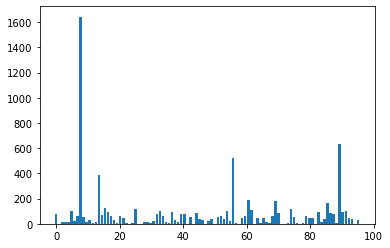

In [21]:
counts, bins = np.histogram(train_labels, bins=100)
plt.bar(bins[:-1],counts)

<BarContainer object of 100 artists>

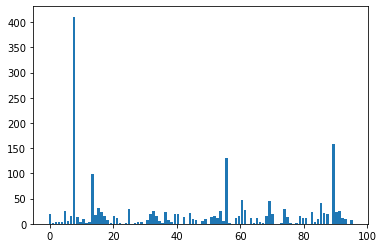

In [22]:
counts, bins = np.histogram(val_labels, bins=100)
plt.bar(bins[:-1],counts)

In [34]:
_, counts = np.unique(labels,return_counts=True)
np.sort(counts)

array([   2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    3,
          3,    3,    3,    5,    5,    6,    7,    8,    9,   10,   10,
         10,   10,   10,   14,   14,   15,   17,   17,   18,   18,   19,
         21,   22,   23,   25,   26,   27,   33,   34,   35,   37,   42,
         43,   44,   49,   49,   52,   53,   54,   54,   57,   57,   58,
         58,   61,   66,   69,   70,   71,   73,   73,   74,   75,   76,
         76,   78,   80,   89,   93,   95,   95,   97,  101,  102,  103,
        109,  115,  116,  118,  119,  126,  127,  128,  129,  135,  143,
        150,  154,  203,  223,  240,  489,  654,  788, 2054])

In [23]:
np.unique(val_labels).shape

(85,)

# Classifier

#### Random forest

In [161]:
data = np.load('ThisData.npy')
labels.shape

(9244,)

In [164]:
# Random Forest

N_Estimators = 150
criterion = 'entropy'

forest = RandomForestClassifier(n_estimators=N_Estimators, criterion=criterion, max_features='sqrt', max_depth=None)
forest.fit(train_data, train_labels)

params = {'id':run_id , 'model':'RF' , 'n_estimators':N_Estimators , 'criterion':criterion}

# SAVE Model
trained_model_path = './trained_models/random_forest/'

joblib.dump(forest , os.path.join(trained_model_path, 'model.pkl'));

In [165]:
pred_labels = forest.predict(val_data)
#pred_labels = forest.predict(data)

### NN

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device = ',device)

X_train = torch.tensor(train_data, dtype=torch.float32)
y_train = torch.tensor(train_labels, dtype=torch.long)

X_val = torch.tensor(val_data, dtype=torch.float32)
y_val = torch.tensor(val_labels, dtype=torch.long)

# data loader
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=50, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=50)

Device =  cuda


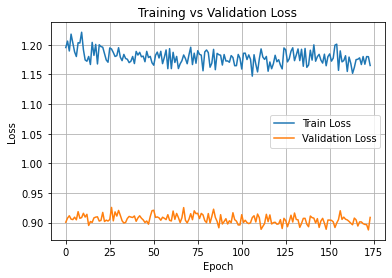

KeyboardInterrupt: 

In [53]:
# Model, Loss, and Optimizer

m = train_data.shape[1]
c = np.unique(train_labels).shape[0]

# Model save path
trained_model_path = './trained_models/nn/best_weights.pth'

model = SimpleNN(m, c)

summary = torch_summary(model,None)

try: 
    pass
    model.load_state_dict(torch.load(trained_model_path))
except:
    pass
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.00002, weight_decay=1e-4)  # Adam optimizer

epochs = 2000
# Early Stopping Parameters
patience = epochs  # Stop if no improvement for 'patience' epochs

params = {'id':run_id , 'model':str(type(model).__name__) , 'epochs':epochs , 'patience':patience , \
          'optimizer':str(type(optimizer).__name__) , 'loss':str(type(criterion).__name__) , \
         'model_summary':[str(summary)]}


train(epochs, model, criterion, optimizer, train_loader, val_loader, trained_model_path, patience)

#### Good values!

we get a good training with dropout 25%, input to 50, 50 to 50, 50 to output
with learning rate 5 10-5 and decay 1e-4

In [46]:
model = SimpleNN(m, c)
model.load_state_dict(torch.load(trained_model_path))
model.to(device)
model.eval()

pred_labels = predict(model, val_loader, device)

In [55]:
model.to(device)
model.eval()

pred_labels = predict(model, val_loader, device)

#### Boosting

In [87]:
adaBoost = AdaBoostClassifier(n_estimators=100)
adaBoost.fit(train_data, train_labels)

AdaBoostClassifier(n_estimators=100)

In [88]:
pred_labels = adaBoost.predict(val_data)

# Scoring

In [166]:
acc = accuracy_score(val_labels, pred_labels)
#acc = accuracy_score(labels, pred_labels)

params.update( {'accuracy':acc} )
write_jsonl(run_log, params)
print(acc)

0.8875067604110329


In [167]:
print(classification_report(val_labels, pred_labels, zero_division=0.0))
#print(classification_report(labels, pred_labels, zero_division=0.0))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           2       1.00      1.00      1.00         3
           3       1.00      0.75      0.86         4
           4       1.00      0.33      0.50         3
           5       0.93      1.00      0.96        25
           6       0.50      0.20      0.29         5
           7       0.94      1.00      0.97        15
           8       0.99      1.00      1.00       411
           9       0.92      0.92      0.92        13
          10       0.75      1.00      0.86         3
          11       0.75      1.00      0.86         9
          12       1.00      0.50      0.67         2
          13       1.00      0.75      0.86         4
          14       0.68      0.91      0.78        98
          15       1.00      1.00      1.00        18
          16       1.00      0.94      0.97        31
          17       0.92      0.96      0.94        23
          18       1.00    

In [168]:
np.unique(pred_labels).shape

(83,)

In [169]:
np.unique(val_labels).shape

(85,)

### Make model persistent

In [50]:
joblib.dump(forest , os.path.join(trained_model_path, 'model'+ str(run_id) +'.pkl'));

NameError: name 'forest' is not defined

In [51]:
absname, ext = os.path.splitext(trained_model_path)
name = absname + str(run_id) + ext
modelname = absname + str(run_id) + 'Model' + ext
torch.save(model.state_dict(), name)
torch.save(model, modelname)


In [91]:
mod = torch.load(modelname, weights_only=False)

('summary',
 'ColumnSettings',
 'Mode',
 'ModelStatistics',
 'RowSettings',
 'Units',
 'Verbosity')

In [129]:
summary = summary.__repr__()

In [143]:
print(summary.summary_list)

[SimpleNN: 0, Linear: 1, Dropout: 1, Linear: 1, Linear: 1, Linear: 1, ReLU: 1]


In [36]:
data[0,:]

array([1.48511409e+01, 1.78557358e+01, 2.05849437e+01, 1.05692155e+04,
       1.74049810e+04, 2.21391528e+04, 8.00000000e+00, 1.30000000e+01,
       0.00000000e+00, 8.30443450e+00, 1.68231757e+01, 1.69238200e+00,
       4.21586000e+00])

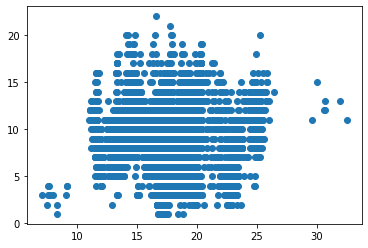

In [80]:
plt.scatter(data[:,0], data[:,7])

In [88]:
removed_cols = [8]
kept_cols = [x for x in range(13) if x not in removed_cols] 
data[:, kept_cols ].shape

(9244, 12)